In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [15, 7]

In [4]:
from os.path import expanduser

SRC_PATH = expanduser("~") + '/SageMaker/mastering-ml-on-aws/chapter5/'

In [5]:
from pyspark.context import SparkContext

sc = SparkContext('local', 'test')

from pyspark.sql import SQLContext

spark = SQLContext(sc)
    

In [6]:
df = spark.read.csv(SRC_PATH + 'data.csv', header=True, inferSchema=True)

In [7]:
df.toPandas().head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
df = df.selectExpr("*","Quantity * UnitPrice as TotalBought")

In [9]:
df.limit(5).toPandas()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalBought
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


In [10]:
customer_df = df.select("CustomerID","TotalBought").groupBy("CustomerID").sum("TotalBought").withColumnRenamed('sum(TotalBought)','SumTotalBought')

In [11]:
customer_df.show(5)

+----------+------------------+
|CustomerID|    SumTotalBought|
+----------+------------------+
|     17420| 598.8300000000002|
|     16861|            151.65|
|     16503|1421.4300000000005|
|     15727| 5178.960000000001|
|     17389|31300.080000000016|
+----------+------------------+
only showing top 5 rows



In [12]:
from pyspark.sql.functions import *

joined_df = df.join(customer_df, 'CustomerId')

In [13]:
joined_df.show(5)

+----------+---------+---------+--------------------+--------+--------------+---------+--------------+------------------+-----------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|       TotalBought|   SumTotalBought|
+----------+---------+---------+--------------------+--------+--------------+---------+--------------+------------------+-----------------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|United Kingdom|15.299999999999999|5288.630000000009|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|United Kingdom|             20.34|5288.630000000009|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|United Kingdom|              22.0|5288.630000000009|
|     17850|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|United Kingdom|             20.34|5288.630000000009|
|     17850|   53636

In [14]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import Normalizer

stages = [ StringIndexer(inputCol='StockCode', outputCol="stock_code_index", handleInvalid='keep'),
           OneHotEncoder(inputCol='stock_code_index', outputCol='stock_code_encoded'),
           StringIndexer(inputCol='Country', outputCol='country_index', handleInvalid='keep'),
           OneHotEncoder(inputCol='country_index', outputCol='country_encoded'),
           QuantileDiscretizer(numBuckets=3, inputCol='SumTotalBought', outputCol='total_bought_index'),
           VectorAssembler(inputCols=['stock_code_encoded','country_encoded', 'total_bought_index'], outputCol='features_raw'),
           Normalizer(inputCol="features_raw", outputCol="features", p=1.0),
           KMeans(featuresCol='features').setK(3).setSeed(42)
         ]

pipeline = Pipeline(stages=stages)

model = pipeline.fit(joined_df)

In [15]:
df_with_clusters = model.transform(joined_df).cache()


In [16]:
df_with_clusters.limit(5).toPandas()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,TotalBought,SumTotalBought,stock_code_index,stock_code_encoded,country_index,country_encoded,total_bought_index,features_raw,features,prediction
0,17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,15.30,5288.63,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,17850,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,20.34,5288.63,403.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,22.00,5288.63,452.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,20.34,5288.63,288.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,20.34,5288.63,281.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [17]:
df_with_clusters.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|127781|
|         2| 44951|
|         0|234097|
+----------+------+



In [18]:
df_with_clusters.where(df_with_clusters.prediction==0).groupBy("Country").count().orderBy("count", ascending=False).show()

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|234097|
+--------------+------+



In [19]:
df_with_clusters.where(df_with_clusters.prediction==1).groupBy("Country").count().orderBy("count", ascending=False).show()

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|127781|
+--------------+------+



In [20]:
df_with_clusters.where(df_with_clusters.prediction==2).groupBy("Country").count().orderBy("count", ascending=False).show()

+---------------+-----+
|        Country|count|
+---------------+-----+
|        Germany| 9495|
|         France| 8491|
|           EIRE| 7485|
|          Spain| 2533|
|    Netherlands| 2371|
|        Belgium| 2069|
|    Switzerland| 1877|
|       Portugal| 1480|
|      Australia| 1259|
|         Norway| 1086|
|          Italy|  803|
|Channel Islands|  758|
|        Finland|  695|
|         Cyprus|  622|
|         Sweden|  462|
|        Austria|  401|
|        Denmark|  389|
|          Japan|  358|
|         Poland|  341|
|            USA|  291|
+---------------+-----+
only showing top 20 rows



In [21]:
pandas_df = df_with_clusters.limit(5000).select('CustomerID','InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Country','TotalBought','SumTotalBought','prediction').toPandas()


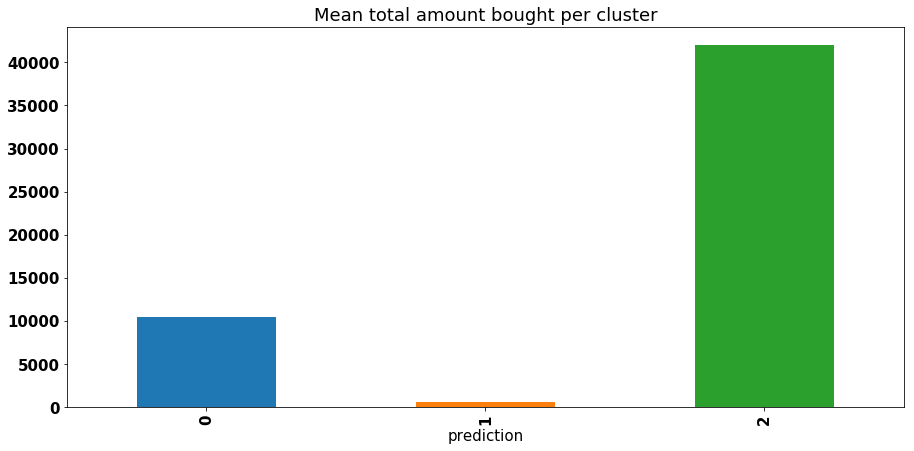

In [35]:
import matplotlib

pandas_df.groupby('prediction').describe()['SumTotalBought']['mean'].plot(kind='bar', title = 'Mean total amount bought per cluster')

In [183]:
pandas_df.groupby('prediction').describe()

CustomerID                                                        \
                count          mean          std      min      25%      50%   
prediction                                                                    
0              2372.0  16043.289207  1711.811134  12748.0  14573.0  16210.0   
1              2279.0  15944.732339  1607.798695  12838.0  14723.0  15923.0   
2               349.0  13229.111748  1045.705565  12395.0  12433.0  12682.0   

                             Quantity              ...   TotalBought          \
                75%      max    count       mean   ...           75%     max   
prediction                                         ...                         
0           17841.0  18239.0   2372.0  15.371417   ...          25.5  1627.2   
1           17552.0  18168.0   2279.0   4.869241   ...          15.0   350.4   
2           14911.0  14911.0    349.0  20.481375   ...          33.9   230.4   

           UnitPrice                                                      
               count      mean       std   min   25%   50%   75%     max  
prediction                                                                
0             2372.0  3.108196  3.304927  0.03  1.25  2.10  3.75   35.75  
1             2279.0  3.338591  7.797187  0.12  1.25  2.10  3.75  295.00  
2              349.0  3.677221  5.361564  0.12  1.25  1.65  3.75   50.00  

[3 rows x 40 columns]

In [36]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(df_with_clusters)


In [37]:
silhouette

0.3471978832087873

In [174]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from functools import reduce
import re
import itertools

def plot_word_cloud(description_column):    
    list_of_word_sets = description_column.apply(str.split).tolist()
    text = list(itertools.chain(*list_of_word_sets))
    text = map(lambda x: re.sub(r'[^A-Z]',r'', x), text)
    text = reduce(lambda x,y: x + ' ' + y, text)
    wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS,
    collocations=False).generate(str(text))
    fig = plt.figure(
        figsize = (10, 5),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


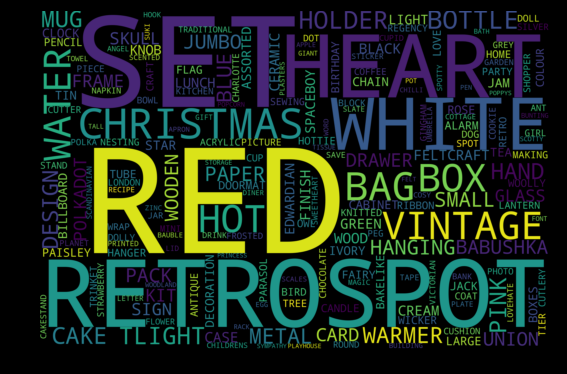

In [175]:
plot_word_cloud(pandas_df[pandas_df.prediction==0].Description)

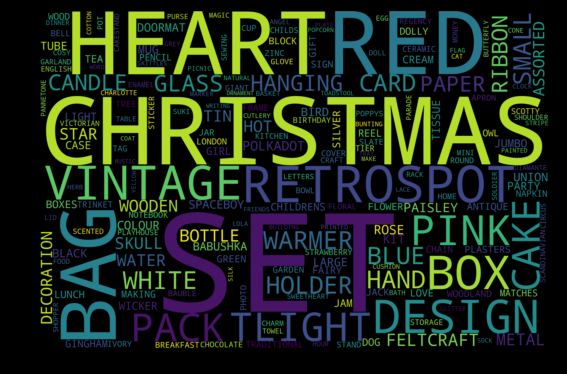

In [176]:
plot_word_cloud(pandas_df[pandas_df.prediction==1].Description)


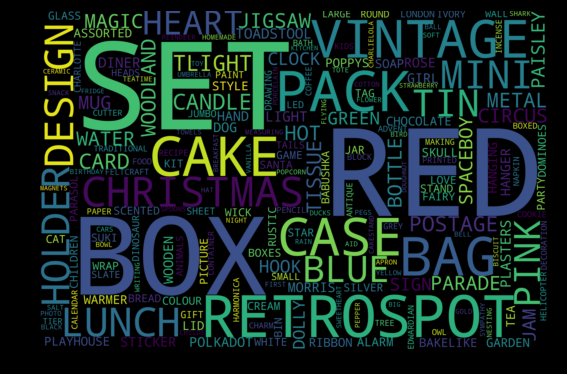

In [177]:
plot_word_cloud(pandas_df[pandas_df.prediction==2].Description)


In [63]:
import boto3 
import json

template = '%s,%s,%s'

def deconstruct_vector(row):
    vect = row['features']
    jsonlines = {'data':{ 'features': {'shape':[int(vect.size)], 'keys':list(map(int,vect.indices)), 'values':list(vect.values)}}}
    return { 'jsonlines': json.dumps(jsonlines) } 

df_for_csv = df_with_clusters.select("features").rdd.map(deconstruct_vector).toDF()
df_for_csv.write.text('s3://mastering-ml-aws/chapter5/training-vector-csv/')
